# E Cigarette Smoke Free Indoor Air Clustering

## ML Assignment 3 : Latent Manifold and Regression

### Course code : CMPE-257
Group name : Spartans <br/>
        Members :
                   * SUDHA AMARNATH
                   * MUKESH RANJAN SAHAY
                   * THIRUMALAI NAMBI DOSS
                   * MUTHU KUMAR SUKUMARAN


#### 1.  Data Story 

The STATE System houses current and historical state-level legislative data on tobacco use prevention and control policies. Data are reported on a quarterly basis. Data include information related to state legislation on smokefree indoor air in areas such as: Bars, Commercial Day Care Centers, Government Multi-Unit Housing, Government Worksites, Home-Based Day Care Centers, Hotels and Motels, Personal Vehicles, Private Multi-Unit Housing, Private Worksites, Restaurants, Bingo Halls, Casinos, Enclosed Arenas, Grocery Stores, Hospitals, Hospital Campuses, Malls, Mental Health Outpatient and Residential Facilities, Prisons, Public Transportation, Racetrack Casinos, Substance Abuse Outpatient and Residential Facilities.


As for the vaping trend analysis, we want to know what kinds of provision locations the e-cigarette trend is high for a given province. In this way, we could find where the e-cigarette smoking is banned, allowed of if there are any fines in the province. 


Following steps are done to arrive at the business conclusion.

1. Identifying your data story with your team
2. Selecting an initial strong data set to conduct all of your homeworks and term long project on.
3. Running linear regression on multiple features (one at a time).
4. Conducting data preparation on your data
5. Conducting data enrichment by adding one or more data sets to your base data set
6. Finding a latent manifold
7. Using the manifold to add features to your data set and run regression or clustering based on those new features.
8. Business Conclusion

#### Team Contribution
a. Data preparation and analysing Measure Description - MUTHU KUMAR SUKUMARAN <br/>
b. Apply Linear Regression and predicting result before data enrichment - MUKESH RANJAN SAHAY <br/>
c. Data Enrichment, apply Linear Regression and Visualizing Results in maps - SUDHA AMARNATH <br/>
d. Identify Latent Manifold and run regression on new features - THIRUMALAI NAMBI DOSS <br/>



#### 2. Dataset Selection 
### [Google Drive Dataset Link1](https://drive.google.com/open?id=14OlNrJvCG8YUnaovZD2uMpySM5UD-A1V) 
### [Google Drive Dataset Link2](https://drive.google.com/open?id=1SFMMrd4fL4J-l_bTiDtBUzMVDHqcdfok) 



### Importing Required Libraries

In [0]:

import random
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import sklearn.cluster.k_means_
import tensorflow as tf
import seaborn as sns
import plotly.graph_objects as go

from time import time
from sklearn import mixture
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.linear_model import LinearRegression

from scipy.spatial.distance import cdist
%matplotlib inline

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
# load the CSV file and create a new DataFrame out of it.
file1 = 'CDC_STATE_System_E-Cigarette_Legislation_-_Smokefree_Indoor_Air.csv'
link = 'https://drive.google.com/open?id=14OlNrJvCG8YUnaovZD2uMpySM5UD-A1V'
fluff, id = link.split('=')
print('File Name = ', file1)
print('File ID = ', id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile(file1)  

#file1 = '/Users/admin/Desktop/aliDatasets/CDC_STATE_System_E-Cigarette_Legislation_-_Smokefree_Indoor_Air.csv'
#df = pd.read_csv(file1,low_memory=False, nrows=100000)
df = pd.read_csv(file1,low_memory=False)
df = df[df['YEAR'] >= 2017] 
df = df.sample(frac=1)
df = df.head(100000).reset_index(drop=True)
print(df.shape)
origdf = df
df.head(2)



File Name =  CDC_STATE_System_E-Cigarette_Legislation_-_Smokefree_Indoor_Air.csv
File ID =  14OlNrJvCG8YUnaovZD2uMpySM5UD-A1V
(98967, 23)


,YEAR,Quarter,LocationAbbr,LocationDesc,TopicDesc,MeasureDesc,DataSource,ProvisionGroupDesc,ProvisionDesc,ProvisionValue,Citation,ProvisionAltValue,DataType,Comments,Enacted_Date,Effective_Date,GeoLocation,DisplayOrder,TopicTypeId,TopicId,MeasureId,ProvisionGroupID,ProvisionID
0,2018,2,GA,Georgia,Legislation - E-Cigarette - Smokefree Indoor Air,Commercial Day Care Centers,OSH,Penalties,Penalty to User,No Provision,NaN,0,Ranking,NaN,NaN,NaN,"(32.83968109300048, -83.62758034599966)",14,LEG,1042LEG,1008CDC,60GRP,608
1,2017,4,OK,Oklahoma,Legislation - E-Cigarette - Smokefree Indoor Air,Smokefree Indoor Air – Other Sites,OSH,Restriction Areas,Grocery Stores,No Provision,NaN,0,Ranking,NaN,NaN,NaN,"(35.47203135600046, -97.52107021399968)",4,LEG,1042LEG,1011SIO,15GRP,719


### Preparing dataset
Replace the given LocationDesc value with the mapped equivalent, LocationID<br/>
Replace the given ProvisionGroupDesc value with the mapped equivalent, ProvisionGroupID<br/>
Replace the given ProvisionValue value with the mapped equivalent, ProvisionValueID<br/>
Replace the given MeasureDesc value with the mapped equivalent, MeasureDescID<br/>
Replace the given ProvisionDesc value with the mapped equivalent, ProvisionDescID<br/>


In [0]:
def mapLatitudeLongitude(df):
    global latMapping, lonMapping
    lat = []
    lon = []
    for row in df['GeoLocation']:
        try:
            lat.append(row.split(',')[0].strip('('))
            lon.append(row.split(',')[1].strip(')'))
        except:
            lat.append(np.NaN)
            lon.append(np.NaN)
    df['Latitude'] = lat
    df['Longitude'] = lon

    lat = df['Latitude'].unique().tolist()
    lon = df['Longitude'].unique().tolist()
    latMapping = dict( zip(lat,range(len(lat))) )
    lonMapping = dict( zip(lon,range(len(lon))) )

mapLatitudeLongitude(df)    
#print(latMapping)
#print(lonMapping)



In [0]:
def mapLocationID(df):
    global locationIndexList, locAbbrIndexList, latitudeIndexList, longitudeIndexList
    location_id = df['LocationDesc'].unique().tolist()
    mapping = dict( zip(location_id,range(len(location_id))) )
    df.replace({'location_id': mapping},inplace=True)
    LocationID = []
    for row in df['LocationDesc']:
        try:
            LocationID.append(mapping[row.strip()])
        except:
            LocationID.append(np.NaN)
    df['LocationID'] = LocationID

    locationIndexList = list(set(LocationID))
    latitudeIndexList = []
    longitudeIndexList = []
    locAbbrIndexList = []

    for i in locationIndexList:
      latitudeIndexList.append(df.loc[df['LocationID'] == i, 'Latitude'].iloc[0])
      longitudeIndexList.append(df.loc[df['LocationID'] == i, 'Longitude'].iloc[0])
      locAbbrIndexList.append(df.loc[df['LocationID'] == i, 'LocationAbbr'].iloc[0])

    latitudeIndexList = list(np.float_(latitudeIndexList))
    longitudeIndexList = list(np.float_(longitudeIndexList))

mapLocationID(df)

#print(locationIndexList)
#print(locAbbrIndexList)

#print(latitudeIndexList)
#print(longitudeIndexList)


In [0]:
def mapProvisionGroupId(df):
    provision_group_id = df['ProvisionGroupDesc'].unique().tolist()
    mapping = dict( zip(provision_group_id,range(len(provision_group_id))) )
    df.replace({'provision_group_id': mapping},inplace=True)

    ProvisionGroupID = []
    for row in df['ProvisionGroupDesc']:
        try:
            ProvisionGroupID.append(mapping[row.strip()])
        except:
            ProvisionGroupID.append(np.NaN)
    df['ProvisionGroupID'] = ProvisionGroupID
    
mapProvisionGroupId(df)

In [0]:
def mapProvisionValueId(df):
    provision_value_id = df['ProvisionValue'].unique().tolist()
    mapping = dict( zip(provision_value_id,range(len(provision_value_id))) )
    df.replace({'provision_value_id': mapping},inplace=True)

    ProvisionValueID = []
    for row in df['ProvisionValue']:
        try:
            ProvisionValueID.append(mapping[row.strip()])
        except:
            ProvisionValueID.append(np.NaN)
    df['ProvisionValueID'] = ProvisionValueID

mapProvisionValueId(df)

In [0]:
def mapMeasureDescId(df):
    measure_desc_id = df['MeasureDesc'].unique().tolist()
    mapping = dict( zip(measure_desc_id,range(len(measure_desc_id))) )
    df.replace({'measure_desc_id': mapping},inplace=True)

    MeasureDescID = []
    for row in df['MeasureDesc']:
        try:
            MeasureDescID.append(mapping[row.strip()])
        except:
            MeasureDescID.append(np.NaN)
    df['MeasureDescID'] = MeasureDescID

mapMeasureDescId(df)

In [0]:
def mapProvisionDescId(df):

    provision_desc_id = df['ProvisionDesc'].unique().tolist()
    mapping = dict( zip(provision_desc_id,range(len(provision_desc_id))) )
    df.replace({'provision_desc_id': mapping},inplace=True)

    ProvisionDescID = []
    for row in df['ProvisionDesc']:
        try:
            ProvisionDescID.append(mapping[row.strip()])
        except:
            ProvisionDescID.append(np.NaN)
    df['ProvisionDescID'] = ProvisionDescID

mapProvisionDescId(df)

### Remove a row or a column from  dataframe which has a NaN or no values in it.


In [0]:
#ProvisionID is ProvisionDesc
#LocationID is LocationDesc
#ProvisionGroupID is ProvisionGroupDesc
#ProvisionValueID is ProvisionValue
#ProvisionDescID is ProvisionDesc
#MeasureDescID is MeasureDesc

df.dropna(subset = ['ProvisionID', 'LocationID', 'ProvisionGroupID', 'ProvisionValueID', 'MeasureDescID','ProvisionDescID'], inplace = True)
print(df.shape)
df.head(2)

(98967, 29)


,YEAR,Quarter,LocationAbbr,LocationDesc,TopicDesc,MeasureDesc,DataSource,ProvisionGroupDesc,ProvisionDesc,ProvisionValue,Citation,ProvisionAltValue,DataType,Comments,Enacted_Date,Effective_Date,GeoLocation,DisplayOrder,TopicTypeId,TopicId,MeasureId,ProvisionGroupID,ProvisionID,Latitude,Longitude,LocationID,ProvisionValueID,MeasureDescID,ProvisionDescID
0,2018,2,GA,Georgia,Legislation - E-Cigarette - Smokefree Indoor Air,Commercial Day Care Centers,OSH,Penalties,Penalty to User,No Provision,NaN,0,Ranking,NaN,NaN,NaN,"(32.83968109300048, -83.62758034599966)",14,LEG,1042LEG,1008CDC,0,608,32.83968109300048,-83.62758034599966,0,0,0,0
1,2017,4,OK,Oklahoma,Legislation - E-Cigarette - Smokefree Indoor Air,Smokefree Indoor Air – Other Sites,OSH,Restriction Areas,Grocery Stores,No Provision,NaN,0,Ranking,NaN,NaN,NaN,"(35.47203135600046, -97.52107021399968)",4,LEG,1042LEG,1011SIO,1,719,35.47203135600046,-97.52107021399968,1,0,1,1


### Set cluster data - Create a cluster data frame cdf having columns `LocationID` and `MeasureDescID`


In [0]:

df_col_value_1 = 'LocationID'
df_col_value_2 = 'MeasureDescID'
# create the cluster data frame cdf
cdf = df.loc[:,[df_col_value_1, df_col_value_2]]
cdf.head()



,LocationID,MeasureDescID
0,0,0
1,1,1
2,2,0
3,3,2
4,4,2


In [0]:
def getRowIndex(ndf, ll):
  ndflocList = ndf['LocationID'].tolist()
  return ndflocList.index(ll)


### Bar graph showing the States Location Distribution

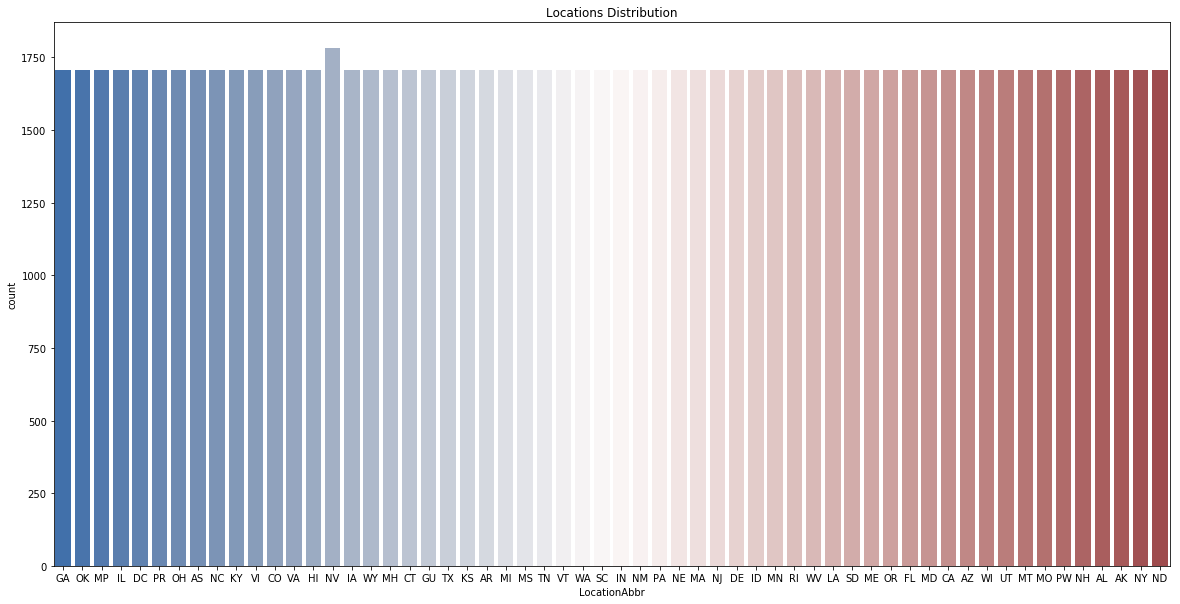

In [0]:
f, ax = plt.subplots(1,1, figsize = (20, 10))
sns.countplot(x=df['LocationAbbr'], ax = ax, palette="vlag")
ax.set_title('Locations Distribution')
plt.show()


### Bar graph showing the number of occurance of the Measure Description Distributions.


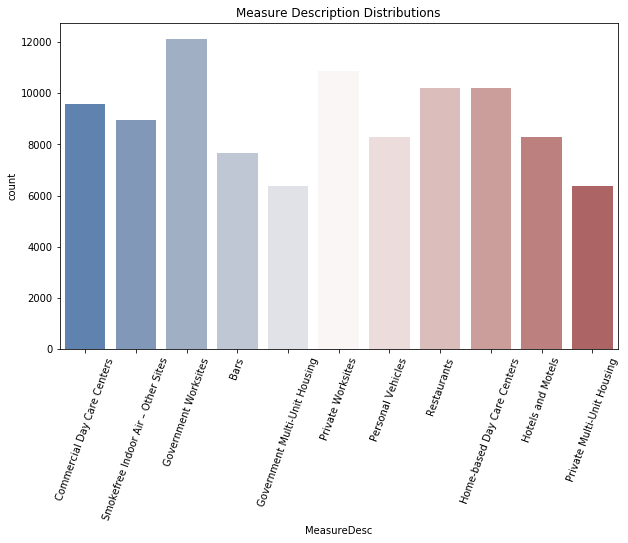

In [0]:
f, ax = plt.subplots(1,1, figsize = (10, 6))
sns.countplot(x=df['MeasureDesc'], ax = ax, palette="vlag")
ax.tick_params('x', rotation = 70)
ax.set_title('Measure Description Distributions')
plt.show()

### Bar graph showing the number of occurance of the Provision Description Distributions.


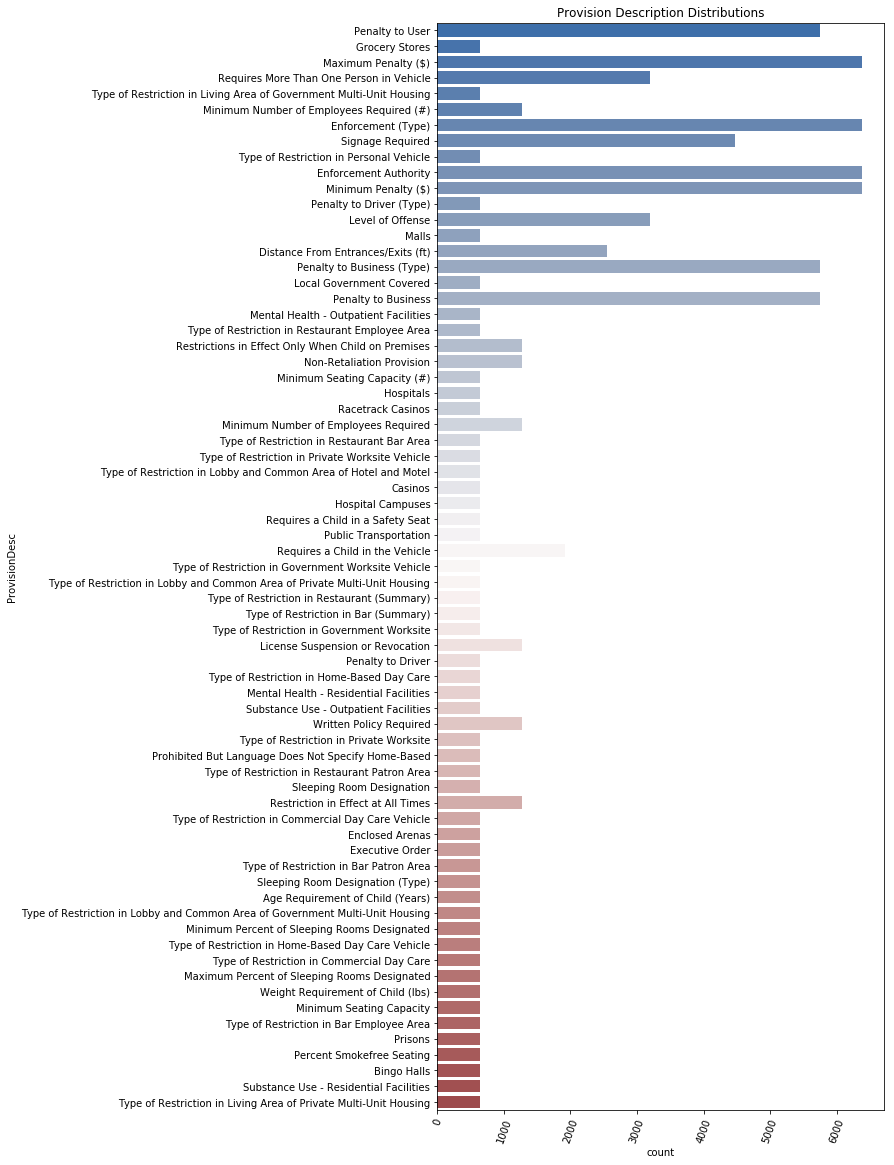

In [0]:
f, ax = plt.subplots(1,1, figsize = (8, 20))
sns.countplot(y=df['ProvisionDesc'], ax = ax, palette="vlag")
ax.tick_params('x', rotation = 70)
ax.set_title('Provision Description Distributions')
plt.show()

### Determining Optimum Clusters using the Elbow method for K-means


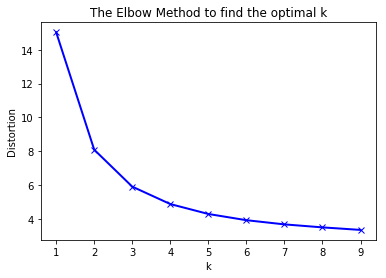

In [0]:
distortions=[]
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k).fit(cdf)
    kmeans.fit(cdf)
    distortions.append(sum(np.min(cdist(cdf, kmeans.cluster_centers_, 'euclidean'), axis=1)) / cdf.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-', linewidth=2)
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method to find the optimal k')
plt.show()



### From the above elbow method plot, the number of optimal clusters N selected is 4


In [0]:
N = 4
print('Selecting optimum N value =', N)
print('Found distortion from elbow method for',N, 'clusters =', distortions[N-1])



Selecting optimum N value = 4
Found distortion from elbow method for 4 clusters = 4.875395675386677


### Function to plot the clusters


In [0]:
def plot_figure(cdf_col1, cdf_col2,labels,centroids=[]):    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 8))
    plt.scatter(cdf_col1, cdf_col2, c=labels, cmap='rainbow', s = 10)
    if len(centroids) > 0:
        plt.scatter(centroids[:, 0], centroids[:, 1], s = 100, c = 'black', label = 'Centroids', marker = 'o')
        plt.legend(loc=(1.05,0.5))
    plt.xlabel(cdf_col1.name)
    plt.ylabel(cdf_col2.name)
    plt.show()


### Clustering performance evaluation for K-means, GMM and Mini-batch Kmeans

#### Metrics Name	  
Adjusted Rand index<br/>
Mutual Information based scores<br/>
Homogeneity, completeness and V-measure<br/>
Fowlkes-Mallows scores<br/>
Calinski-Harabaz Index<br/>
Davies-Bouldin Index<br/>
Contingency Matrix<br/>

Initializing `metricsdf` for calculating metrics 


In [0]:
metricsdf = pd.DataFrame(index=['KMEANS','GMM', 'MBK'], 
                         columns=['ARI','MI','HCV','FM','CH','DB'])

XX = cdf[df_col_value_1]
YY = cdf[df_col_value_2]

# intially all cells are NaN
metricsdf


,ARI,MI,HCV,FM,CH,DB
KMEANS,NaN,NaN,NaN,NaN,NaN,NaN
GMM,NaN,NaN,NaN,NaN,NaN,NaN
MBK,NaN,NaN,NaN,NaN,NaN,NaN


### Function for the performace evaluation for related metrics for KMEANS, GMM, and Mini-batch K-means


In [0]:
def calcMetrics(algorithm):
    # Get metrics data for the algorithms
    metricsdf.loc[algorithm,'ARI'] = metrics.adjusted_rand_score(YY, labels)
    metricsdf.loc[algorithm,'MI']  = metrics.adjusted_mutual_info_score(YY, labels)
    metricsdf.loc[algorithm,'HCV'] = metrics.homogeneity_score(YY, labels)
    metricsdf.loc[algorithm,'FM'] = metrics.fowlkes_mallows_score(YY, labels)
    metricsdf.loc[algorithm,'CH'] = metrics.calinski_harabasz_score(cdf, labels)
    metricsdf.loc[algorithm,'DB'] = metrics.davies_bouldin_score(cdf, labels)
    return


### Implementing Gaussian Mixture  Model in Scikit learn framework



Time taken to train with GMM Model is 0.56 seconds


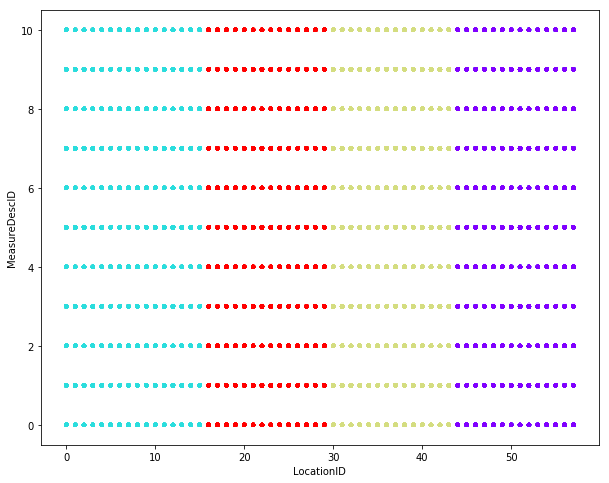

In [0]:
# N is taken from elbow method that was found using k-means
gmm = mixture.GaussianMixture(n_components=N, covariance_type='tied', random_state = 0)
t0 = time()
gmm.fit(cdf)
train_time = time() - t0
print("\nTime taken to train with GMM Model is %0.2f seconds" % train_time)
labels = gmm.predict(cdf)
calcMetrics('GMM')
plot_figure(cdf[df_col_value_1], cdf[df_col_value_2], labels)



### Implementation of Mini Batch KMeans alogorithm using Scikit learn framework



Time taken to train with MiniBatchKMeans Model is 0.39 seconds


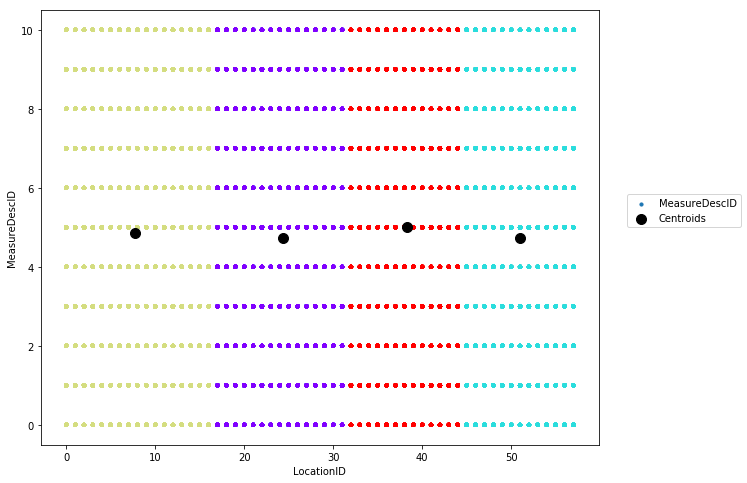

In [0]:
from sklearn.cluster import MiniBatchKMeans

mbk = MiniBatchKMeans(init='k-means++', n_clusters=4, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0)
t0 = time()
mbk.fit(cdf)
t_mini_batch = time() - t0
print("\nTime taken to train with MiniBatchKMeans Model is %0.2f seconds" % t_mini_batch)
labels = mbk.labels_
centroids = mbk.cluster_centers_
calcMetrics('MBK')

plot_figure(cdf[df_col_value_1], cdf[df_col_value_2], labels, centroids)

### Implementation of K-means algorithm using Scikit learn framework



Time taken to train with KMeans Model using ScikitLearn is 0.80 seconds


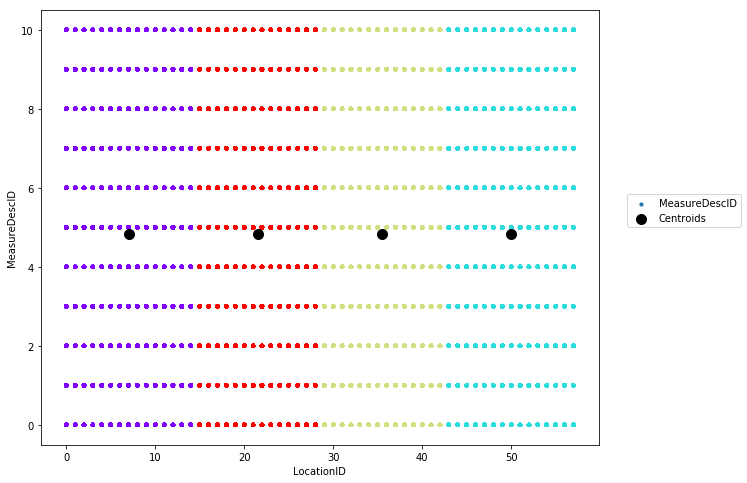

In [0]:
# Using number of clusters N

kmeans = KMeans(init='k-means++', n_clusters = N, random_state = 0, max_iter = 500)
t0 = time()
kmeans.fit(cdf)
train_time = time() - t0
print("\nTime taken to train with KMeans Model using ScikitLearn is %0.2f seconds" % train_time)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
calcMetrics('KMEANS')
plot_figure(cdf[df_col_value_1], cdf[df_col_value_2], labels, centroids)


### Clustering performance evaluation - KMEANS, GMM, Mini Batch Kmeans


In [0]:
print('\nCompare performance of the Scikit Learn Clustering Models')
print('As we can see, KMEANS, Mini Batch Kmeans are almost same and better than GMM')
metricsdf


Compare performance of the Scikit Learn Clustering Models
As we can see, KMEANS, Mini Batch Kmeans are almost same and better than GMM


,ARI,MI,HCV,FM,CH,DB
KMEANS,-4.56159e-05,-6.35996e-05,1.17433e-07,0.15357,318370,0.676695
GMM,-4.46604e-05,-6.36095e-05,1.0755e-07,0.153761,316777,0.676846
MBK,-4.34784e-05,-6.36183e-05,9.88274e-08,0.154497,310454,0.68343


### Linear Regression Plot before Data Enrichment - (LocationID, ProvisionGroupID)

7.061628282123422e-09


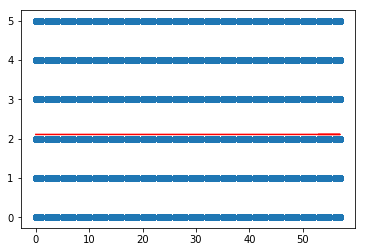

In [0]:
x = df.loc[:, ['LocationID']]
y = df.loc[:, ['ProvisionGroupID']]

reg = LinearRegression().fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x, y)  
plt.plot(x,predict,color = 'red')
plt.show()

### Linear Regression Plot before Data Enrichment - (LocationID, MeasureDescID)

4.3908850999585525e-09


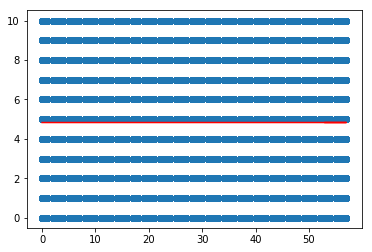

In [0]:
x = df.loc[:, ['LocationID']]
y = df.loc[:, ['MeasureDescID']]

reg = LinearRegression().fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x, y)  
plt.plot(x,predict,color = 'red')
plt.show()

### Linear Regression Plot before Data Enrichment - (ProvisionGroupID, MeasureDescID)

0.002689777018688999


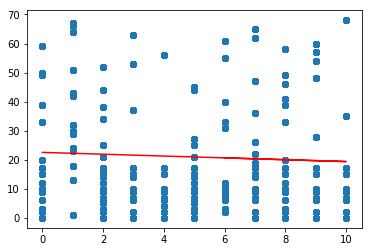

In [0]:
y = df.loc[:, ['ProvisionDescID']]
x = df.loc[:, ['MeasureDescID']]

reg = LinearRegression().fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x, y)  
plt.plot(x,predict,color = 'red')
plt.show()

### Data Enrichment - Pre Latent manifold

In [0]:

rdf = df.groupby(["LocationID", "MeasureDesc"]).size().reset_index(name="Restricted")

indexNames = rdf[(rdf['MeasureDesc'] != "Bars") & (rdf['MeasureDesc'] != "Restaurants") & (rdf['MeasureDesc'] != "Government Worksites") & (rdf['MeasureDesc'] != "Private Worksites")].index
rdf.drop(indexNames , inplace=True)
print(rdf.shape)
print(rdf.head())

bannedList = ['Bars', 'Restaurants', 'Government Worksites', 'Private Worksites']

ndf = pd.DataFrame(rdf.LocationID.unique(), columns =['LocationID'])
for bl in bannedList:
  ndf[bl] = 0

locList = ndf.LocationID.unique().tolist()

for ll in locList:
    for bl in bannedList:
        try:
          val = rdf.loc[(rdf['LocationID'] == ll) & (rdf['MeasureDesc'] == bl), 'Restricted'].values[0]
          rowindex = getRowIndex(ndf, ll)
          if rowindex != -1:
            ndf.set_value(rowindex, bl, val)
          else:
            print(False, ndf.at[ll, 'LocationID'])
        except:
          ndf.set_value(rowindex, bl, 0)

ndf = ndf.fillna(0)
ndf.head()


(232, 3)
    LocationID           MeasureDesc  Restricted
0            0                  Bars         132
3            0  Government Worksites         209
8            0     Private Worksites         187
9            0           Restaurants         176
11           1                  Bars         132


,LocationID,Bars,Restaurants,Government Worksites,Private Worksites
0,0,132,176,209,187
1,1,132,176,209,187
2,2,132,176,209,187
3,3,132,176,209,187
4,4,132,176,209,187


### Enrichement with new data set for only Bars, Restaurants and Worksites

In [0]:
for bl in bannedList:        
  ndf[bl] = pd.to_numeric(ndf[bl], errors='ignore')          

ndf['Restricted'] = ndf['Bars'] + ndf['Restaurants'] + ndf['Government Worksites'] + ndf['Private Worksites']

ndf['Latitude'] = ''
ndf['Longitude'] = ''


loc = ndf['LocationID'].unique().tolist()
locMapping = dict( zip(loc,range(len(loc))) )

#print(locationIndexList)
#print(latitudeIndexList)
#print(longitudeIndexList)
#print(locAbbrIndexList)


for ll in locList:
    locidxval = locationIndexList[ll]
    locidxvalndf = locList.index(ll)
    latval = latitudeIndexList[locidxval]
    lonval = longitudeIndexList[locidxval]
    abbval = locAbbrIndexList[locidxval]
    ndf.set_value(locidxvalndf, 'Latitude', latval )
    ndf.set_value(locidxvalndf, 'Longitude', lonval )
    ndf.set_value(locidxvalndf, 'LocationAbbr', abbval )
    
ndf.head(100)

,LocationID,Bars,Restaurants,Government Worksites,Private Worksites,Restricted,Latitude,Longitude,LocationAbbr
0,0,132,176,209,187,704,32.8397,-83.6276,GA
1,1,132,176,209,187,704,35.472,-97.5211,OK
2,2,132,176,209,187,704,15.0979,145.674,MP
3,3,132,176,209,187,704,40.485,-88.9977,IL
4,4,132,176,209,187,704,38.8904,-77.032,DC
5,5,132,176,209,187,704,18.2208,-66.5901,PR
6,6,132,176,209,187,704,40.0602,-82.4043,OH
7,7,132,176,209,187,704,-14.3016,-170.696,AS
8,8,132,176,209,187,704,35.4662,-79.1593,NC
9,9,132,176,209,187,704,37.646,-84.775,KY


### Map Visualization pre enrichment - It only has Bars, Restaurants and Worksites

In [0]:
for col in ndf.columns:
    ndf[col] = ndf[col].astype(str)

ndf['text'] = ndf['LocationAbbr'] + '<br>' + \
    'Bars: ' + ndf['Bars'] + '<br>' + 'Restaurants: ' + ndf['Restaurants'] + '<br>' + \
    'Government Worksites: ' + ndf['Government Worksites'] + '<br>' + 'Private Worksites: ' + ndf['Private Worksites'] + '<br>'

fig = go.Figure(data=go.Choropleth(
    locations=ndf['LocationAbbr'],
    z=ndf['Restricted'].astype(float),
    locationmode='USA-states',
    colorscale='Earth',
    zmin = min(ndf['Restricted'].astype(float)) - 0,
    zmax = max(ndf['Restricted'].astype(float)),
    autocolorscale=False,
    text=ndf['text'], # hover text
    marker_line_color='white', # line markers between states
    colorbar_title="Restricted"
))

fig.update_layout(
    title_text='Comprehensive = Restricted in worksites, restaurants, and bars as of Q3 2019.<br>(Hover for breakdown)',
    autosize=False,
    width=1200,
    height=800,
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.show()

### Data Enrichement - to merge Two data sets

In [0]:

file2 = 'CDC_STATE_System_E-Cigarette_Legislation_-_Smokefree_Campus.csv'
link = 'https://drive.google.com/open?id=1SFMMrd4fL4J-l_bTiDtBUzMVDHqcdfok'
fluff, id = link.split('=')
print('File Name = ', file2)
print('File ID = ', id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile(file2)  

sf = pd.read_csv(file2,low_memory=False)
sf = sf[sf['YEAR'] >= 2017] 
sf = sf.sample(frac=1)
sf = sf.head(100000).reset_index(drop=True)
print(sf.corrwith(origdf, axis = 1))
df = pd.concat([origdf, sf])

print(sf.shape)
print(df.shape)

# Create indices for df
mapLatitudeLongitude(df)    
mapLocationID(df)
mapProvisionGroupId(df)
mapProvisionValueId(df)
mapMeasureDescId(df)
mapProvisionDescId(df)

df.head(5)


File Name =  CDC_STATE_System_E-Cigarette_Legislation_-_Smokefree_Campus.csv
File ID =  1SFMMrd4fL4J-l_bTiDtBUzMVDHqcdfok
0        0.999649
1        0.996372
2        0.995527
3        0.999268
4        0.993064
5        0.999974
6        0.999210
7        0.998953
8        0.999813
9        0.996636
10       0.999595
11       0.997044
12       0.999022
13       0.997521
14       0.999669
15       0.999983
16       0.998345
17       0.997426
18       0.998662
19       0.999551
20       0.998534
21       0.990660
22       0.997630
23       0.999934
24       0.997254
25       0.997068
26       0.998843
27       0.996303
28       0.999543
29       0.998927
           ...   
98937         NaN
98938         NaN
98939         NaN
98940         NaN
98941         NaN
98942         NaN
98943         NaN
98944         NaN
98945         NaN
98946         NaN
98947         NaN
98948         NaN
98949         NaN
98950         NaN
98951         NaN
98952         NaN
98953         NaN
98954         

,Citation,Comments,DataSource,DataType,DisplayOrder,Effective_Date,Enacted_Date,GeoLocation,Latitude,LocationAbbr,LocationDesc,LocationID,Longitude,MeasureDesc,MeasureDescID,MeasureId,ProvisionAltValue,ProvisionDesc,ProvisionDescID,ProvisionGroupDesc,ProvisionGroupID,ProvisionID,ProvisionValue,ProvisionValueID,Quarter,TopicDesc,TopicId,TopicTypeId,YEAR
0,NaN,NaN,OSH,Ranking,14,NaN,NaN,"(32.83968109300048, -83.62758034599966)",32.83968109300048,GA,Georgia,0,-83.62758034599966,Commercial Day Care Centers,0,1008CDC,0,Penalty to User,0,Penalties,0,608,No Provision,0,2,Legislation - E-Cigarette - Smokefree Indoor Air,1042LEG,LEG,2018
1,NaN,NaN,OSH,Ranking,4,NaN,NaN,"(35.47203135600046, -97.52107021399968)",35.47203135600046,OK,Oklahoma,1,-97.52107021399968,Smokefree Indoor Air – Other Sites,1,1011SIO,0,Grocery Stores,1,Restriction Areas,1,719,No Provision,0,4,Legislation - E-Cigarette - Smokefree Indoor Air,1042LEG,LEG,2017
2,6 CMC § 3183,NaN,OSH,Money,13,1/20/2017,12/28/2016,"(15.0979, 145.6739)",15.0979,MP,Northern Mariana Islands,2,145.6739,Commercial Day Care Centers,0,1008CDC,200,Maximum Penalty ($),2,Penalties,0,607,200,1,4,Legislation - E-Cigarette - Smokefree Indoor Air,1042LEG,LEG,2018
3,NaN,NaN,OSH,Ranking,10,NaN,NaN,"(40.48501028300046, -88.99771017799969)",40.48501028300046,IL,Illinois,3,-88.99771017799969,Government Worksites,2,1003GWK,0,Requires More Than One Person in Vehicle,3,Vehicles,2,629,No Provision,0,2,Legislation - E-Cigarette - Smokefree Indoor Air,1042LEG,LEG,2018
4,D.C. CODE ANN. § 7-741.04,NaN,OSH,Yes/No,17,11/18/2016,11/18/2016,"(38.89037138500049, -77.03196112699965)",38.89037138500049,DC,District of Columbia,4,-77.03196112699965,Government Worksites,2,1003GWK,2,Penalty to User,0,Penalties,0,788,Yes,2,3,Legislation - E-Cigarette - Smokefree Indoor Air,1042LEG,LEG,2018


### Correlation map for the data frame columns

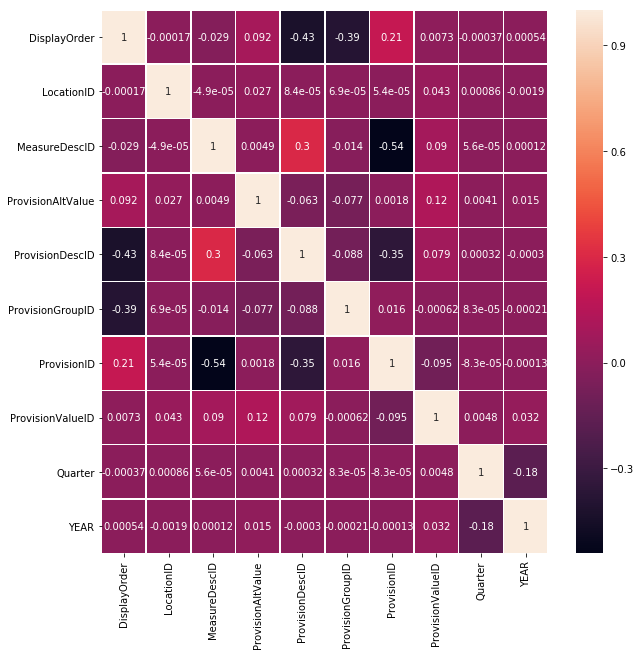

In [0]:

Cor = df[df.columns] 
#Calculate the correlation of the above variables
cor = Cor.corr() 
 #Plot the correlation as heat map
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(cor,annot=True,linewidths=.5, ax=ax)

### Post Data Enrichment: Bar Graph showing Messure Description (It includes Public and Private Schools now)

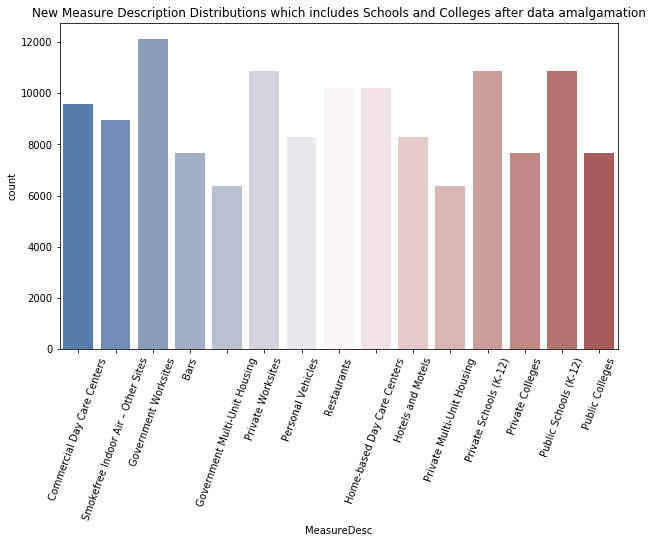

In [0]:
f, ax = plt.subplots(1,1, figsize = (10, 6))
sns.countplot(x=df['MeasureDesc'], ax = ax, palette="vlag")
ax.tick_params('x', rotation = 70)
ax.set_title('New Measure Description Distributions which includes Schools and Colleges after data amalgamation')
plt.show()

### Data Enrichment - Post Latent manifold (It includes Public and Private Schools now)

In [0]:

rdf = df.groupby(["LocationID", "MeasureDesc"]).size().reset_index(name="Restricted")

indexNames = rdf[(rdf['MeasureDesc'] != "Bars") & \
                 (rdf['MeasureDesc'] != "Restaurants") & \
                 (rdf['MeasureDesc'] != "Government Worksites") & \
                 (rdf['MeasureDesc'] != "Private Worksites") & \
                 (rdf['MeasureDesc'] != "Public Colleges") & \
                 (rdf['MeasureDesc'] != "Private Colleges") & \
                 (rdf['MeasureDesc'] != "Private Schools (K-12)") & \
                 (rdf['MeasureDesc'] != "Public Schools (K-12)")].index
rdf.drop(indexNames , inplace=True)
print(rdf.shape)
print(rdf.head(8))

bannedList = ['Bars', 'Restaurants', 'Government Worksites', 'Private Worksites', \
              'Public Colleges', 'Public Schools (K-12)', 'Private Colleges', 'Private Schools (K-12)']

ndf = pd.DataFrame(rdf.LocationID.unique(), columns =['LocationID'])
for bl in bannedList:
  ndf[bl] = 0

locList = ndf.LocationID.unique().tolist()

for ll in locList:
    for bl in bannedList:
        try:
          val = rdf.loc[(rdf['LocationID'] == ll) & (rdf['MeasureDesc'] == bl), 'Restricted'].values[0]
          rowindex = getRowIndex(ndf, ll)
          if rowindex != -1:
            ndf.set_value(rowindex, bl, val)
          else:
            print(False, ndf.at[ll, 'LocationID'])
        except:
          ndf.set_value(rowindex, bl, 0)

ndf = ndf.fillna(0)

print('\nNew NDF data structure includes all Public and Private Schools along with Bars, Restaurants, Worksites\n')
ndf.head()

(464, 3)
    LocationID             MeasureDesc  Restricted
0            0                    Bars         132
3            0    Government Worksites         209
7            0        Private Colleges         132
9            0  Private Schools (K-12)         187
10           0       Private Worksites         187
11           0         Public Colleges         132
12           0   Public Schools (K-12)         187
13           0             Restaurants         176

New NDF data structure includes all Public and Private Schools along with Bars, Restaurants, Worksites



,LocationID,Bars,Restaurants,Government Worksites,Private Worksites,Public Colleges,Public Schools (K-12),Private Colleges,Private Schools (K-12)
0,0,132,176,209,187,132,187,132,187
1,1,132,176,209,187,132,187,132,187
2,2,132,176,209,187,132,187,132,187
3,3,132,176,209,187,132,187,132,187
4,4,132,176,209,187,132,187,132,187


### Total Restricted count of Bars, Restaurants, Worksites and Scools are calculated - post enrichment

In [0]:
for bl in bannedList:        
  ndf[bl] = pd.to_numeric(ndf[bl], errors='ignore')          

bannedList = ['Bars', 'Restaurants', 'Government Worksites', 'Private Worksites', \
              'Public Colleges', 'Public Schools (K-12)', 'Private Colleges', 'Private Schools (K-12)']

ndf['RestrictedAdults'] = ndf['Bars'] + ndf['Restaurants'] + ndf['Government Worksites'] + ndf['Private Worksites']
ndf['RestrictedYouth'] = ndf['Public Colleges'] + ndf['Public Schools (K-12)'] + ndf['Private Colleges'] + ndf['Private Schools (K-12)']

ndf['RestrictedTotal'] = ndf['RestrictedAdults'] + ndf['RestrictedYouth']

ndf['Latitude'] = ''
ndf['Longitude'] = ''

loc = ndf['LocationID'].unique().tolist()
locMapping = dict( zip(loc,range(len(loc))) )

for ll in locList:
    locidxval = locationIndexList[ll]
    locidxvalndf = locList.index(ll)
    latval = latitudeIndexList[locidxval]
    lonval = longitudeIndexList[locidxval]
    abbval = locAbbrIndexList[locidxval]
    ndf.set_value(locidxvalndf, 'Latitude', latval )
    ndf.set_value(locidxvalndf, 'Longitude', lonval )
    ndf.set_value(locidxvalndf, 'LocationAbbr', abbval )
    
ndf.head(5)

,LocationID,Bars,Restaurants,Government Worksites,Private Worksites,Public Colleges,Public Schools (K-12),Private Colleges,Private Schools (K-12),RestrictedAdults,RestrictedYouth,RestrictedTotal,Latitude,Longitude,LocationAbbr
0,0,132,176,209,187,132,187,132,187,704,638,1342,32.8397,-83.6276,GA
1,1,132,176,209,187,132,187,132,187,704,638,1342,35.472,-97.5211,OK
2,2,132,176,209,187,132,187,132,187,704,638,1342,15.0979,145.674,MP
3,3,132,176,209,187,132,187,132,187,704,638,1342,40.485,-88.9977,IL
4,4,132,176,209,187,132,187,132,187,704,638,1342,38.8904,-77.032,DC


### Linear Regression post data enrichment (manifold) - For (LocationID, RestrictedAdults)

0.01316180728359706


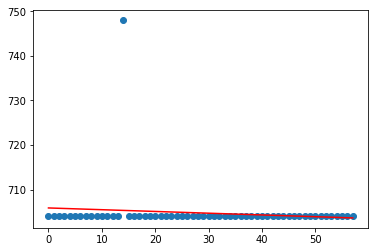

In [0]:
x = ndf.loc[:, ['LocationID']]
y = ndf.loc[:, ['RestrictedAdults']]
reg = LinearRegression().fit(x, y)
print(reg.score(x,y))
predict = reg.predict(x)
plt.scatter(x, y)  
plt.plot(x,predict,color = 'red')
plt.show()

### Linear Regression post data enrichment (manifold) - For (LocationID, RestrictedYouth)

0.01633310022674317


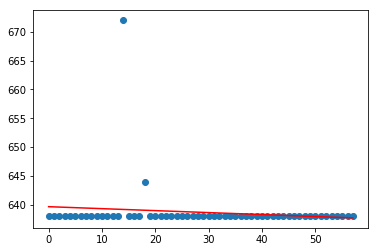

In [0]:
x = ndf.loc[:, ['LocationID']]
y = ndf.loc[:, ['RestrictedYouth']]
reg = LinearRegression().fit(x, y)
print(reg.score(x,y))
predict = reg.predict(x)
plt.scatter(x, y)  
plt.plot(x,predict,color = 'red')
plt.show()

### Linear Regression post data enrichment (manifold) - For (ProvisionDescID, MeasureDescID)

0.08950811883570677


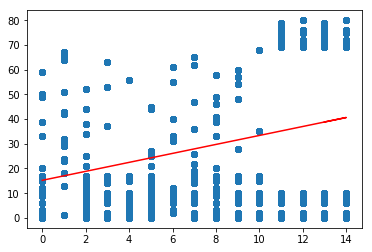

In [0]:
y = df.loc[:, ['ProvisionDescID']]
x = df.loc[:, ['MeasureDescID']]

reg = LinearRegression().fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x, y)  
plt.plot(x,predict,color = 'red')
plt.show()

### Comprehensive = Total Restricted in worksites, restaurants, bars and schools as of Q3 2019 Interactive Map Plot

In [0]:
for col in ndf.columns:
    ndf[col] = ndf[col].astype(str)

ndf['text'] = ndf['LocationAbbr'] + '<br>' + \
    'Bars: ' + ndf['Bars'] + '<br>' + \
    'Restaurants: ' + ndf['Restaurants'] + '<br>' + \
    'Government Worksites: ' + ndf['Government Worksites'] + '<br>' + \
    'Private Worksites: ' + ndf['Private Worksites'] + '<br>' + \
    'Private Schools (K-12): ' + ndf['Private Schools (K-12)'] + '<br>' + \
    'Public Schools (K-12): ' + ndf['Public Schools (K-12)'] + '<br>' + \
    'Private Colleges: ' + ndf['Private Colleges'] + '<br>' + \
    'Public Colleges: ' + ndf['Public Colleges'] + '<br>'

fig = go.Figure(data=go.Choropleth(
    locations=ndf['LocationAbbr'],
    z=ndf['RestrictedTotal'].astype(float),
    locationmode='USA-states',
    colorscale='Earth',
    zmin = min(ndf['RestrictedTotal'].astype(float)) - 0,
    zmax = max(ndf['RestrictedTotal'].astype(float)),
    autocolorscale=False,
    text=ndf['text'], # hover text
    marker_line_color='white', # line markers between states
    colorbar_title="RestrictedTotal"
))

fig.update_layout(
    title_text='Comprehensive = Restricted in worksites, restaurants, bars and schools as of Q3 2019.<br>(Hover for breakdown)',
    autosize=False,
    width=1200,
    height=800,
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.show()

### Clusters Analysis

The clustering is done based on the `Location` and the `Measurement Description` at each location. KMeans Clusetring method is performed for the data frames using Scikit learn frameworks. GMM clusering and Mini Batch K-Means clustering are run using Scikit learn method. The clustering data set had 2 columns and nearly 175k rows. Using elbow method the optimum clusers are selected as N=4. The clusters are well defined and are visualized using the matlab scatter plots. Also the `Scikit Learn Metrics` are calculated to compare the clustering methods and it is found for this data set for 175K rows, the KMEANS algorithm is better than GMM or Mini Batch KMEANS. <br/>



### Map Analysis, New develpments and Insights

An interactive map as of Q3 2019 is visualized using Matlab Plotly Choropleth displaying USA States. Total Restricted count that is sum of Measure Description Parameters of Bars, Restaurants, Government Worksites and Private Worksites are calculated per state. This data is displayed when hovering over each state on the USA Map. For the data selected with 175K rows, following insights can be noticed.

1. All states have restrictions to some extent.
2. State Nevada tops the list. 
3. Almost all the remaining have nearly same usage and restrictions from both the data sets. 

### Data Enrichment, Linear Regression and Latent Manifold
Initially we plotted the Linear regression for our first data set which has only content about the smokefree indoor air restrictions for Measure Descriptions in Bars, Restaurants and Worksites. We have plotted for different columns (LocationID, ProvisionGroupDescID), (LocationID, MeasureDescID), (ProvisionDescID, MeasureDescID). Later we found that we could also include smokefree restrictions in campus for Youth. We enriched the two data sets and selectively created new colums to finally calculate the Total Restrictions, Restrictions for Adults and Youth Separately. Then we again re ran the Linear regressions for the data.

### Business Conclusion

* How does this improve the interpretability of your model?
    - In our use case, Linear Regression is used to predict Measure Description feature against our Provision Descrition ID and Location based Description ID. We have plotted the visualization of counts for smokefree indoor air for restaurants, bars, and worksites for adults using Location Based Maps with the first data set. Later we found that data about the Youth in Colleges are missing. We have used latent manifold to enrich the data selectively using different columns and totalling the restricted counts for both adults and youth.
* How does it add value to your business case?
    - In our usecase, we have again visualized the complete restricted counts for smokefree indoor air for both adults and youth using latent manifold. Then post enrichment we have done linear regression for Provision ID, Measure Descrition and Location ID based e-cigarette smokefree indoor air and campus 